# Figure 2 First Draft

Here I am working out the different panels that will eventually be figure 2.

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.plotting import flip_ticks, add_color_labels, cluster_cmap

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

last updated: 2018-08-10 
Git hash: b88aaf44a6d67b9e2cb49ff250d0e4f3165ba77e


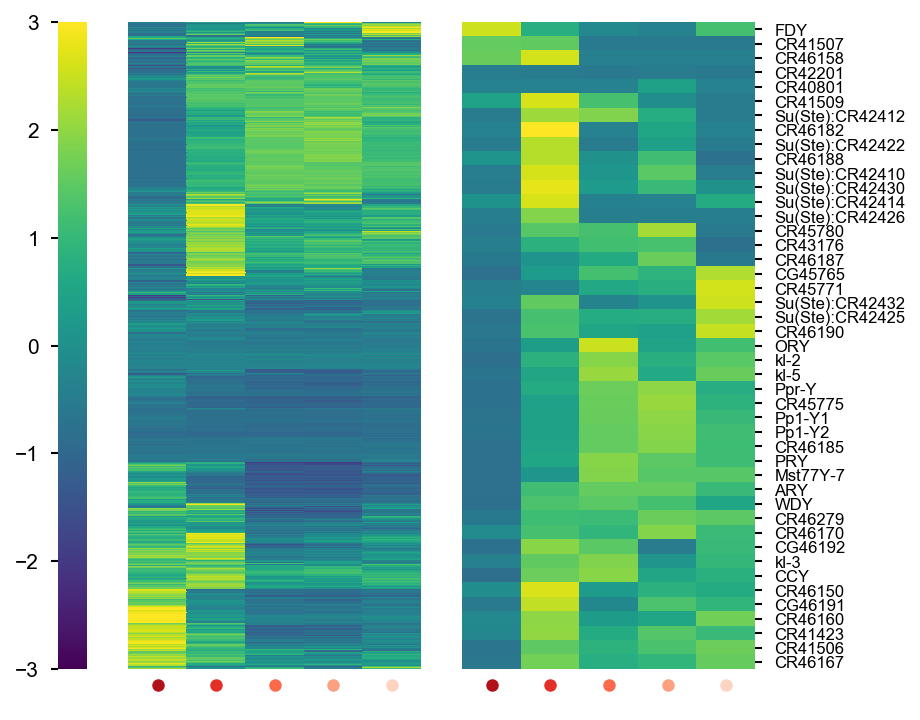

In [17]:
def plot_x_y(axX, axXLabel, axY, axYLabel, x_kws=None, y_kws=None):
    x_kws = x_kws or {}
    y_kws = x_kws or {}
    
    germ_cells = nbconfig.cluster_order[:5]

    dat = pd.read_parquet('../output/scrnaseq-wf/tpm_zscore.parquet', columns=germ_cells).join(nbconfig.fbgn2chrom)

    dat.index = dat.index.map(nbconfig.fbgn2symbol)

    chrX = dat.query('chrom == "chrX"').drop('chrom', axis=1)
    chrY = dat.query('chrom == "chrY"').drop('chrom', axis=1)

    tree = dendrogram(linkage(chrX.values, 'average'), no_plot=True)
    Xleaves = tree['leaves']

    tree = dendrogram(linkage(chrY.values, 'average'), no_plot=True)
    Yleaves = tree['leaves']

    Xdefaults = dict(cmap='viridis', xticklabels=False, yticklabels=False, vmin=-3, vmax=3, ax=axX)
    Xdefaults.update(x_kws)
    
    Ydefaults = dict(cmap='viridis', xticklabels=False, yticklabels=True, vmin=-3, vmax=3, ax=axY)
    Ydefaults.update(y_kws)

    sns.heatmap(chrX.iloc[Xleaves], **Xdefaults)
    sns.heatmap(chrY.iloc[Yleaves], **Ydefaults)

    flip_ticks(axCbar)
    add_color_labels(axXLabel, germ=True)
    add_color_labels(axYLabel, germ=True)

    axX.set_ylabel('')
    axY.set_ylabel('')

    flip_ticks(axY, pos='right')
    plt.setp(axY.get_yticklabels(), rotation=0, fontsize=8);
    
fig = plt.figure()
gs = GridSpec(2, 3, height_ratios=[1, 0.05], width_ratios=[0.1, 1, 1], hspace=0)
axCbar = fig.add_subplot(gs[0, 0])
axX = fig.add_subplot(gs[0, 1])
axXLabel = fig.add_subplot(gs[1, 1])
axY = fig.add_subplot(gs[0, 2])
axYLabel = fig.add_subplot(gs[1, 2])

plot_x_y(axX, axXLabel, axY, axYLabel, x_kws=dict(cbar_ax=axCbar))

In [232]:
dat = np.log1p(pd.read_parquet('../output/scrnaseq-wf/tpm.parquet')).join(nbconfig.fbgn2chrom)
dat.chrom.value_counts()

chr3R    3510
chr3L    2903
chr2R    2897
chr2L    2798
chrX     2189
chr4      102
chrY       45
chrM       18
Name: chrom, dtype: int64

In [233]:
dat.chrom = dat.chrom.map(dict(chr2L='A', chr2R='A', chr3L='A', chr3R='A', chrX='X', chr4='4', chrY='Y'))
dat.chrom.value_counts()

A    12108
X     2189
4      102
Y       45
Name: chrom, dtype: int64

## Distirbution of expression by muller element

Text(0.09,0.5,'Normalized Expression (TPM)')

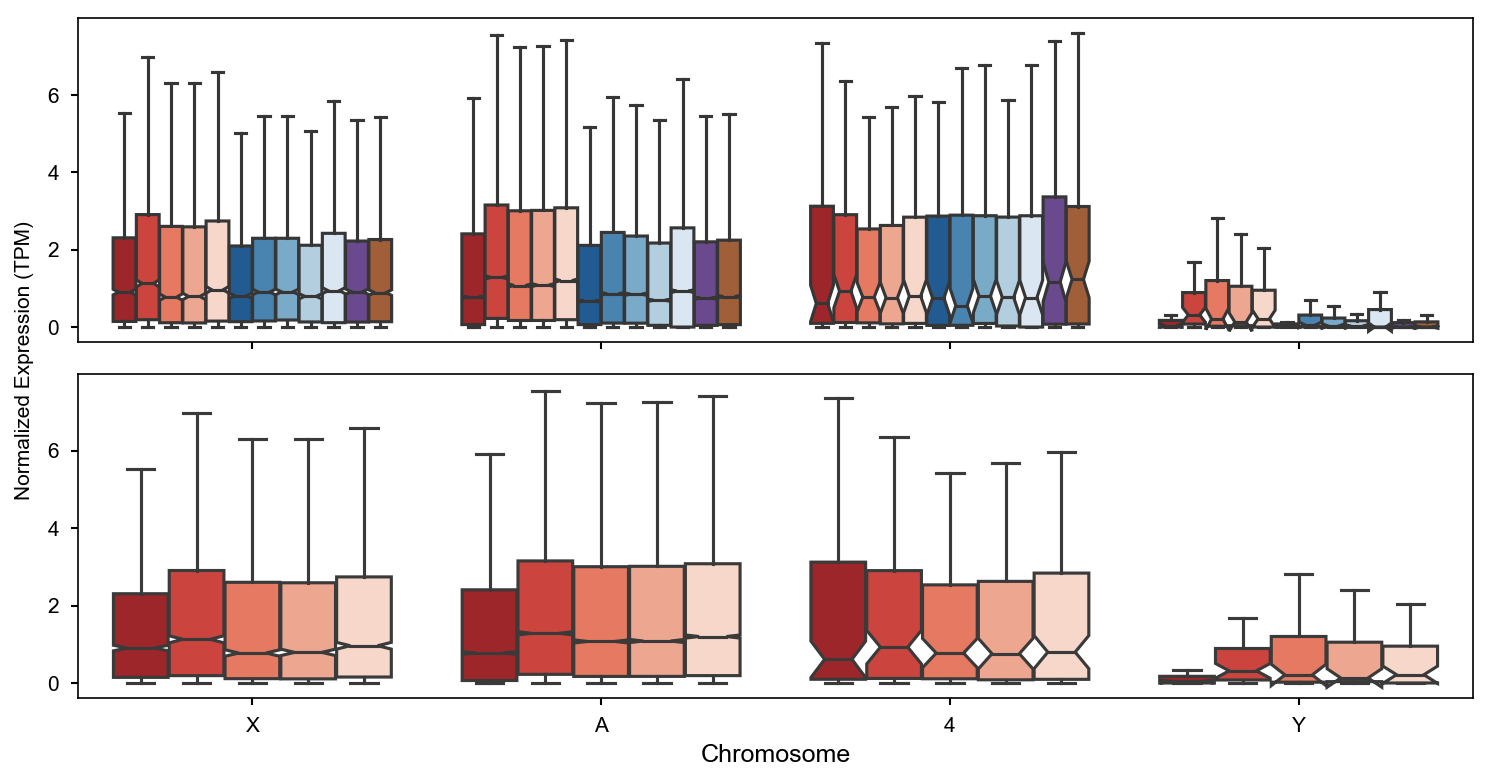

In [136]:
tidy = dat.reset_index().melt(id_vars=['FBgn', 'chrom'], var_name='cluster', value_name='Normalized Expression (TPM)')
tidy.rename(dict(chrom='Chromosome'), axis=1, inplace=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=plt.figaspect(1/2), sharex=True, gridspec_kw=dict(hspace=0.1), sharey=True)
sns.boxplot('Chromosome', 'Normalized Expression (TPM)', data=tidy, hue='cluster', order=['X', 'A', '4', 'Y'], showfliers=False, notch=True, palette=cluster_cmap, ax=ax1)
sns.boxplot('Chromosome', 'Normalized Expression (TPM)', data=tidy.query(f'cluster == {germ_cells}'), hue='cluster', order=['X', 'A', '4', 'Y'], showfliers=False, notch=True, palette=cluster_cmap, ax=ax2)
ax1.legend_.set_visible(False)
ax2.legend_.set_visible(False)

ax1.set_xlabel('')

ax1.set_ylabel('')
ax2.set_ylabel('')
fig.text(0.09, 0.5, 'Normalized Expression (TPM)', rotation=90, fontsize=10, va='center', ha='left')

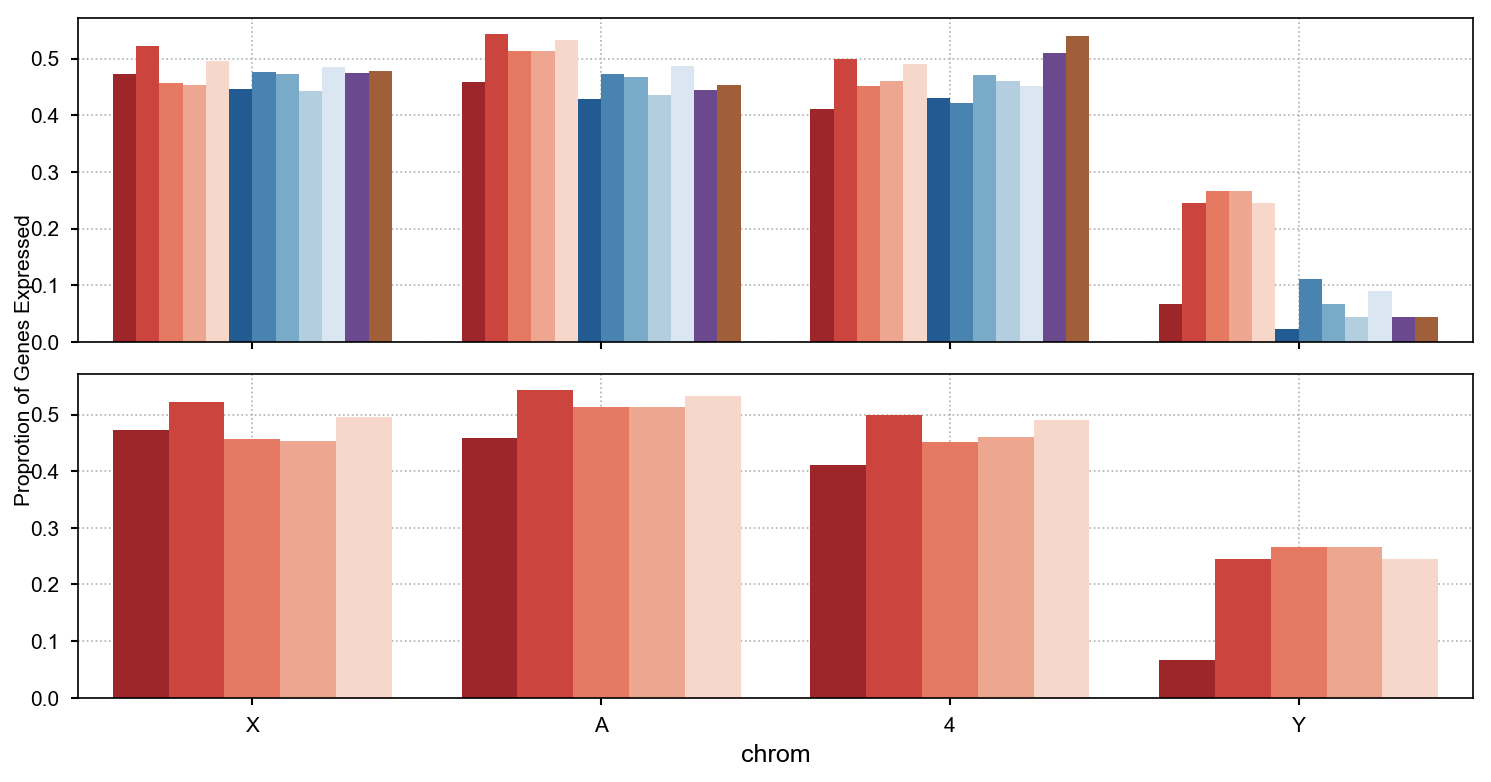

In [345]:
num_genes = dat.groupby('chrom').size()

prop_on = (dat.set_index('chrom', append=True) > 1).groupby('chrom').sum().div(num_genes, axis=0)

tidy = prop_on.reset_index().melt(id_vars='chrom', var_name='cluster', value_name='Proportion Genes Expressed')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=plt.figaspect(1/2), sharex=True, gridspec_kw=dict(hspace=0.1), sharey=True)
sns.barplot('chrom', 'Proportion Genes Expressed', data=tidy, hue='cluster', palette=cluster_cmap, order=['X', 'A', '4', 'Y'], ax=ax1)
sns.barplot('chrom', 'Proportion Genes Expressed', data=tidy.query(f'cluster == {germ_cells}'), hue='cluster', palette=cluster_cmap, order=['X', 'A', '4', 'Y'], ax=ax2)
ax1.legend_.set_visible(False)
ax2.legend_.set_visible(False)

ax1.set_xlabel('')

ax1.set_ylabel('')
ax2.set_ylabel('')
fig.text(0.09, 0.5, 'Proprotion of Genes Expressed', rotation=90, fontsize=10, va='center', ha='left')

ax1.set_axisbelow(True)
ax1.grid(linestyle=':')

ax2.set_axisbelow(True)
ax2.grid(linestyle=':')

## X to A ratio of Medians

In [357]:
meds = dat.groupby('chrom').median()

ratio = meds.T['X'] / meds.T['A']
ratio = ratio.loc[nbconfig.cluster_order].copy()

Text(0,0.5,'X to Autosome Ratio (of Medians)')

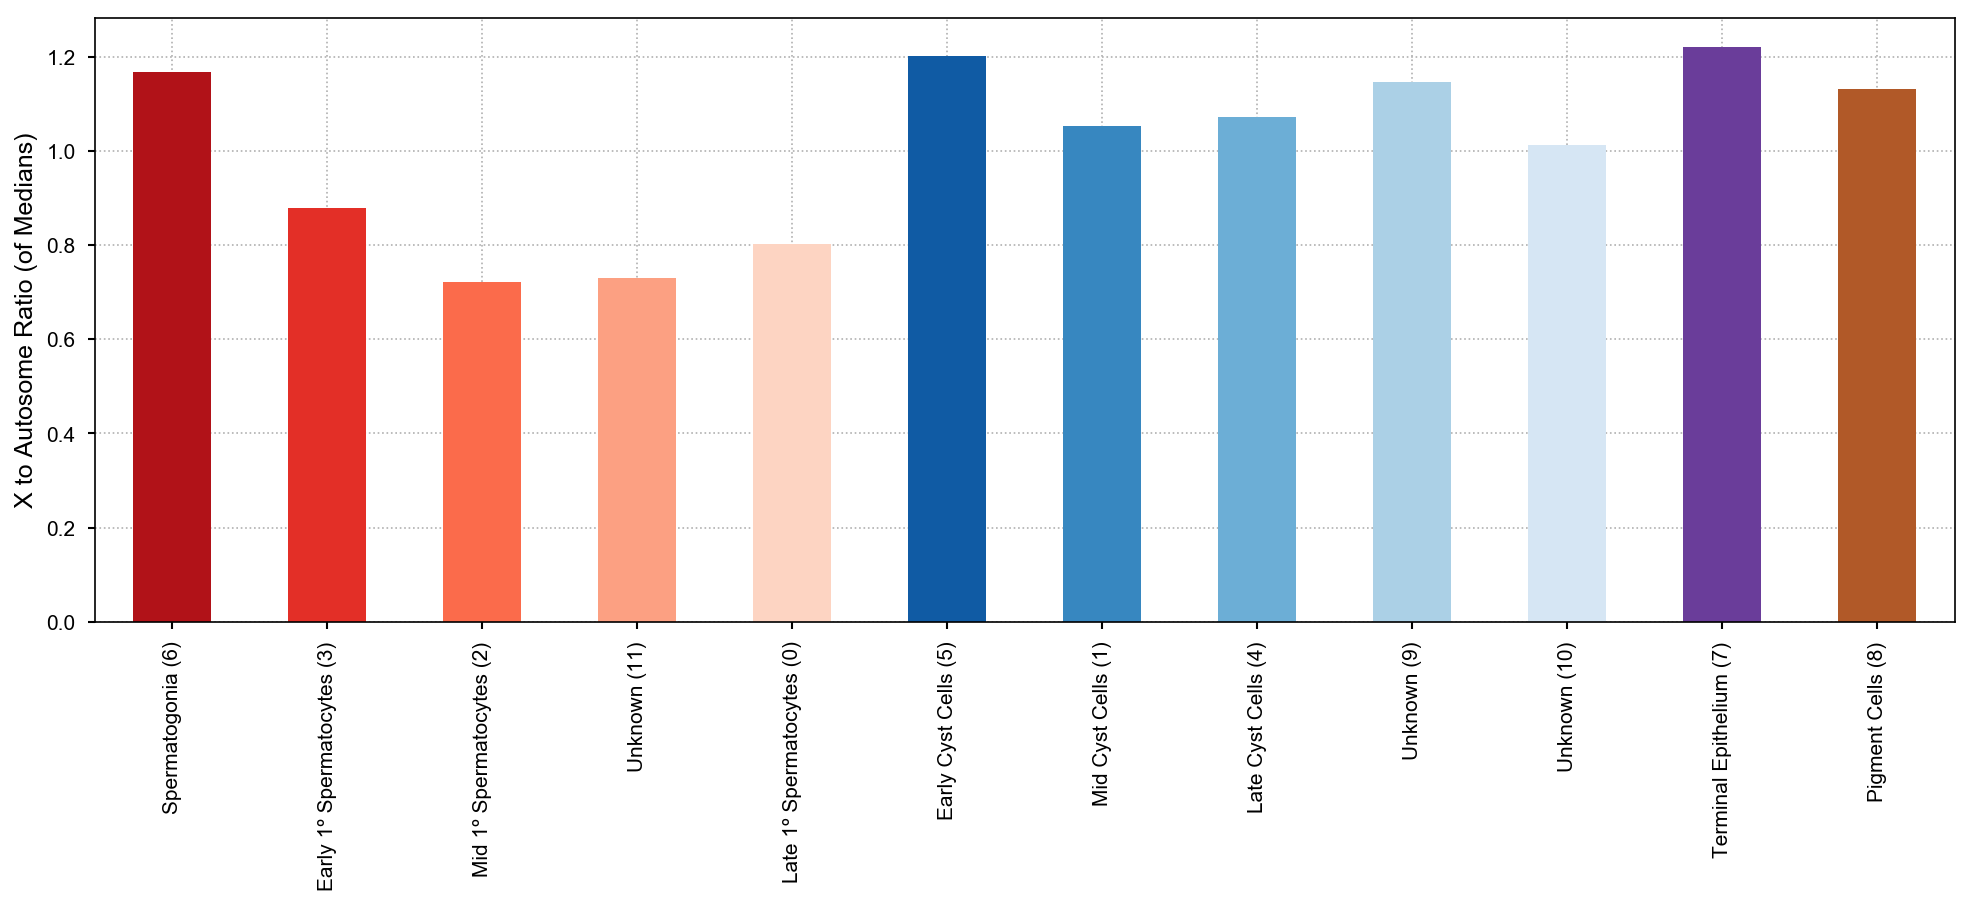

In [361]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/3))
colors = [cluster_cmap[x] for x in ratio.index]
ratio.plot.bar(color=colors, ax=ax)
ax.set_axisbelow(True)
ax.grid(linestyle=':')
ax.set_ylabel('X to Autosome Ratio (of Medians)')

In [111]:
ax.grid?

Signature: ax.grid(b=None, which='major', axis='both', **kwargs)
Docstring:
Turn the axes grids on or off.

Set the axes grids on or off; *b* is a boolean.  (For MATLAB
compatibility, *b* may also be a string, 'on' or 'off'.)

If *b* is *None* and ``len(kwargs)==0``, toggle the grid state.  If
*kwargs* are supplied, it is assumed that you want a grid and *b*
is thus set to *True*.

*which* can be 'major' (default), 'minor', or 'both' to control
whether major tick grids, minor tick grids, or both are affected.

*axis* can be 'both' (default), 'x', or 'y' to control which
set of gridlines are drawn.

*kwargs* are used to set the grid line properties, e.g.,::

   ax.grid(color='r', linestyle='-', linewidth=2)

Valid :class:`~matplotlib.lines.Line2D` kwargs are

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array 
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: bool 
  antialiased or aa: [True | False] 
  clip

In [369]:
scaled = dat.groupby('chrom').sum().div(num_genes, axis=0).T
ratio = scaled['X'] / scaled['A']

Text(0,0.5,'X to Autosome Ratio (of Scaled Sum)')

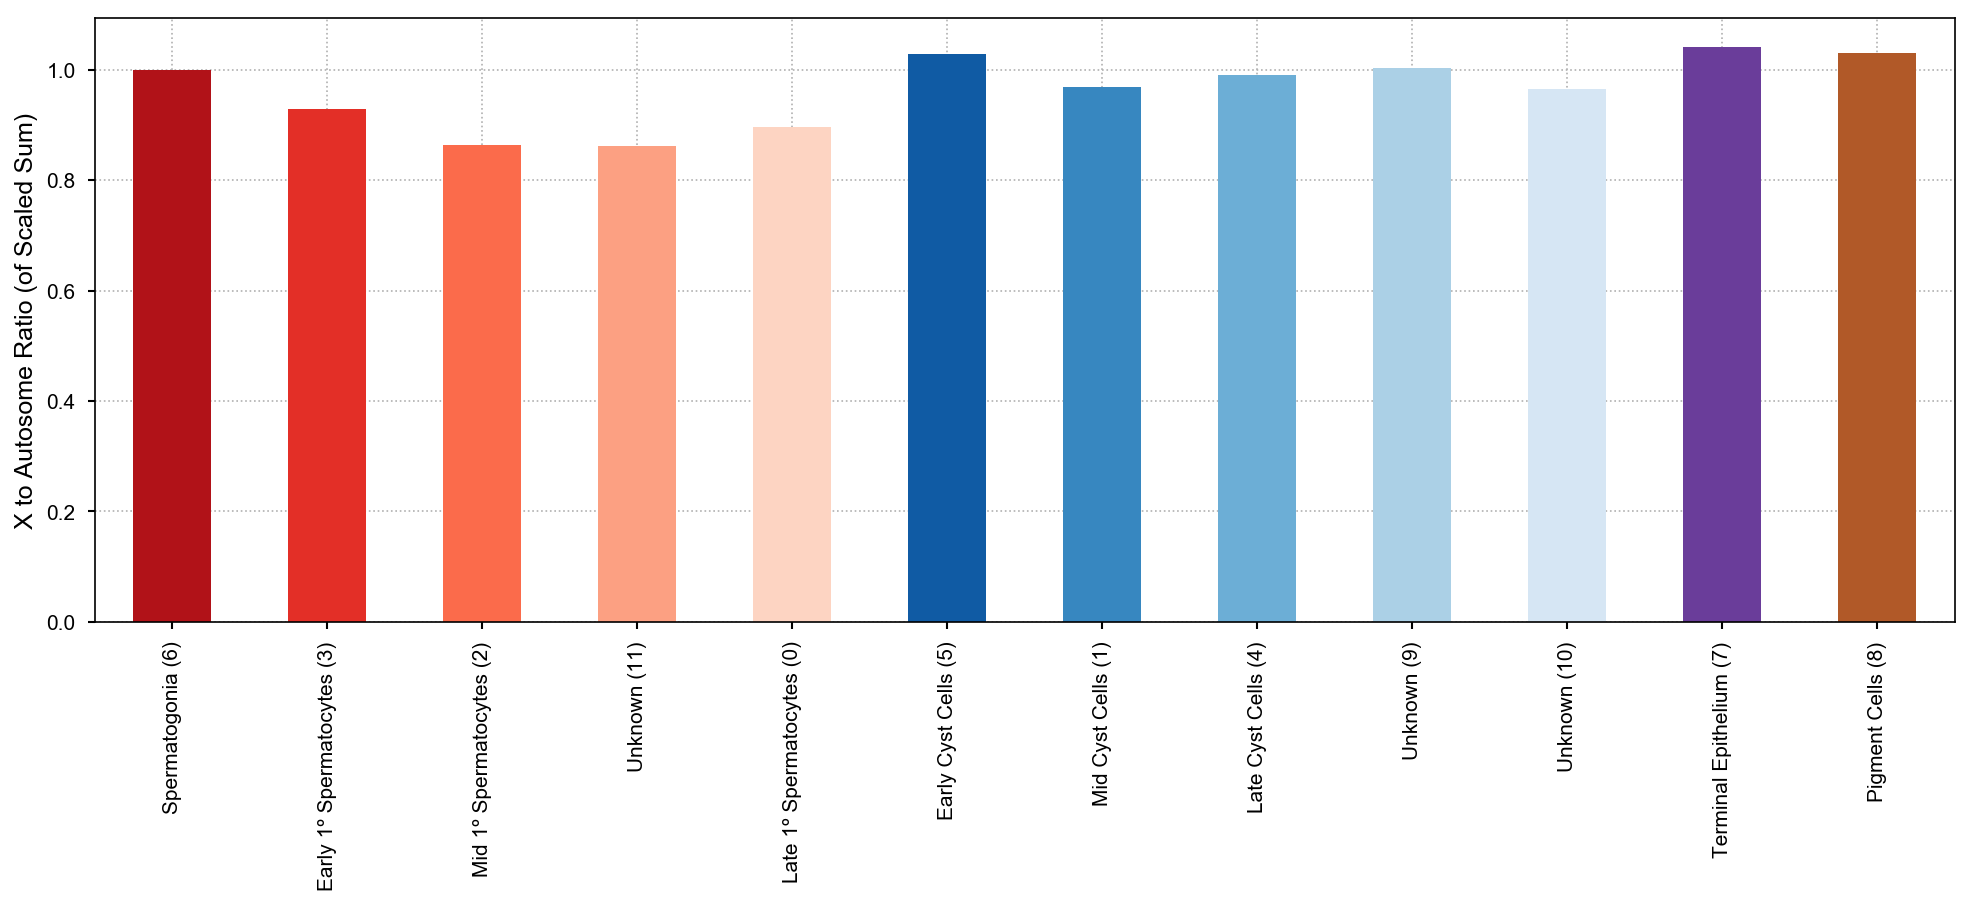

In [372]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/3))
colors = [cluster_cmap[x] for x in ratio.index]
ratio.plot.bar(color=colors, ax=ax)
ax.set_axisbelow(True)
ax.grid(linestyle=':')
ax.set_ylabel('X to Autosome Ratio (of Scaled Sum)')

## Pseudotime

In [3]:
psTime = pd.read_csv('../output/pseudotime-wf/pseudotime.tsv', sep='\t', usecols=['cell_id', 'Pseudotime', 'State'], index_col='cell_id')
psTime.sort_values('Pseudotime', inplace=True)

In [4]:
psTime.head()

,Pseudotime,State
cell_id,,
rep1_TTTGTCAAGCGTCAAG,0.000000,1
rep1_TTGGCAATCACAATGC,0.025494,1
rep1_CACTCCATCAAAGTAG,0.122315,1
rep1_ACGATACAGATAGCAT,0.125214,1
rep1_CATTATCGTCATATCG,0.265501,1


In [46]:
dat = pd.read_csv('../output/scrnaseq-wf/scrnaseq_combine_force/raw.tsv', sep='\t').loc[:, psTime.index]

In [3]:
dat = pd.read_parquet('../output/paper_submission/raw_germcells.parquet')

In [4]:
dat.shape

(14476, 6630)

In [52]:
not_zero = dat.sum(axis=1) > 0

In [54]:
dat = dat.loc[not_zero].copy()

In [55]:
dat.shape

(14419, 6630)

In [56]:
from larval_gonad.normalization import tpm, zscore

In [57]:
gene_lengths = pd.read_csv('../output/gene_ts_lengths.tsv', sep='\t', index_col=0).gene_ts_length

In [58]:
_tpm = tpm(dat, gene_lengths).dropna()

In [59]:
_zscores = zscore(_tpm).dropna()

In [60]:
_zscores.head()

cell_id,rep1_TTTGTCAAGCGTCAAG,rep1_TTGGCAATCACAATGC,rep1_CACTCCATCAAAGTAG,rep1_ACGATACAGATAGCAT,rep1_CATTATCGTCATATCG,rep1_TGAGGGAGTCCGACGT,rep1_GTAGGCCGTGACCAAG,rep1_CAGGTGCAGATGCCTT,rep1_CAGGTGCAGGGCACTA,rep1_CTGATAGAGTGTACCT,...,rep1_CAGCAGCAGGCCGAAT,rep1_CTACGTCCATGACGGA,rep1_AGGTCATTCAATCACG,rep1_CTCGGAGGTCCGTCAG,rep1_TGAGGGAGTCCTGCTT,rep1_ACTTTCAAGCACACAG,rep1_ATTGGACAGAGCTATA,rep1_ACCAGTAGTCTCGTTC,rep1_CGCTTCATCTGATACG,rep1_CATGCCTCACTACAGT
FBgn0000008,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,...,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135,-0.079135
FBgn0000014,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,...,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170,-0.112170
FBgn0000015,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,...,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530,-0.044530
FBgn0000017,1.910754,1.285802,1.666147,1.843845,3.984388,1.260007,0.105513,2.703763,0.851827,1.411981,...,-0.216064,-0.216064,-0.216064,-0.216064,-0.216064,-0.216064,-0.216064,-0.216064,-0.216064,-0.216064
FBgn0000018,0.804169,-0.212572,-0.212572,-0.212572,-0.212572,-0.212572,0.248625,0.485351,0.170313,-0.212572,...,-0.212572,-0.212572,-0.212572,-0.212572,-0.212572,-0.212572,-0.212572,-0.212572,-0.212572,-0.212572


In [61]:
np.percentile(_zscores.values, 5), np.percentile(_zscores.values, 95)

(-0.52153030166500114, 0.74214838293877006)

In [79]:
_dat = _zscores.join(nbconfig.fbgn2chrom).query('chrom == "chrX"').drop('chrom', axis=1)

tree = dendrogram(linkage(_dat, 'average'), no_plot=True)
leaves = tree['leaves']

sns.heatmap(_dat.iloc[leaves], xticklabels=False, yticklabels=False, rasterized=True, cmap='viridis', vmin=-0.5, vmax=.75)

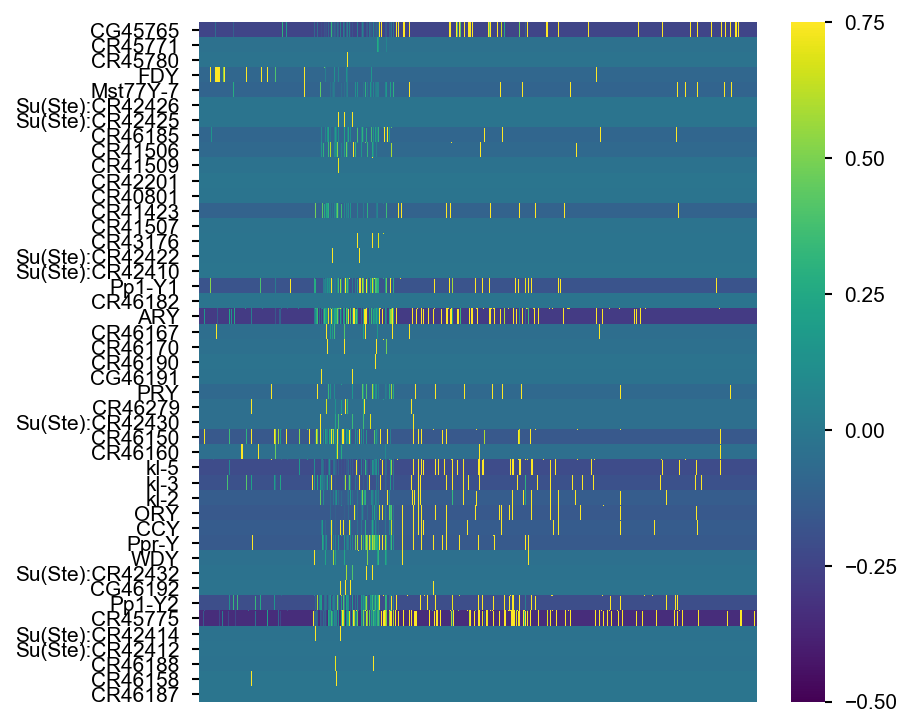

In [109]:
_dat = _zscores.join(nbconfig.fbgn2chrom).query('chrom == "chrY"').drop('chrom', axis=1)
_dat.index = _dat.index.map(nbconfig.fbgn2symbol)

tree = dendrogram(linkage(_dat, 'average'), no_plot=True)
leaves = tree['leaves']

sns.heatmap(_dat.iloc[leaves], xticklabels=False, yticklabels=True, rasterized=True, cmap='viridis', vmin=-0.5, vmax=.75)

Text(0.5,0.1,'Pseudotime')

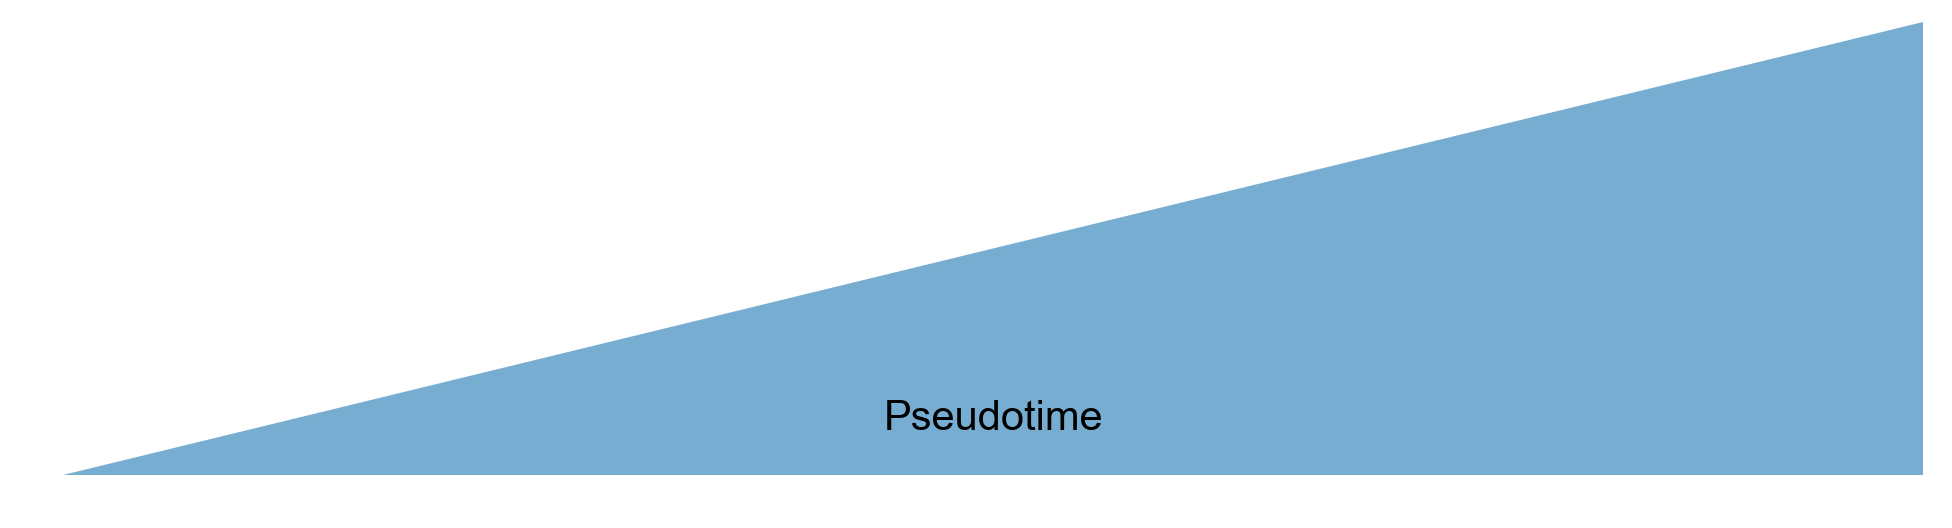

In [106]:
fig, ax = plt.subplots(figsize=plt.figaspect(1/4))
points = [[0, 0], [1, 0], [1, 1]]
polygon = plt.Polygon(points, alpha=.6)
ax.add_artist(polygon)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
ax.text(0.5, .1, 'Pseudotime', ha='center', )

In [430]:
fbgn2chrom = nbconfig.fbgn2chrom.copy()
fbgn2chrom.chrom.replace(dict(chrX='X', chr2L='A', chr2R='A', chr3L='A', chr3R='A'), inplace=True)

In [431]:
raw = pd.read_parquet('../output/paper_submission/raw_germcells.parquet').join(fbgn2chrom)

In [432]:
totals = raw.groupby('chrom').sum().div(fbgn2chrom.groupby('chrom').size(), axis=0).T

In [433]:
ratio = totals['X'] / totals['A']

In [434]:
ratio.name = 'X2A'

In [435]:
psTime = pd.read_parquet('../output/paper_submission/pseudotime.parquet')

In [440]:
dat = psTime.join(ratio)

[]

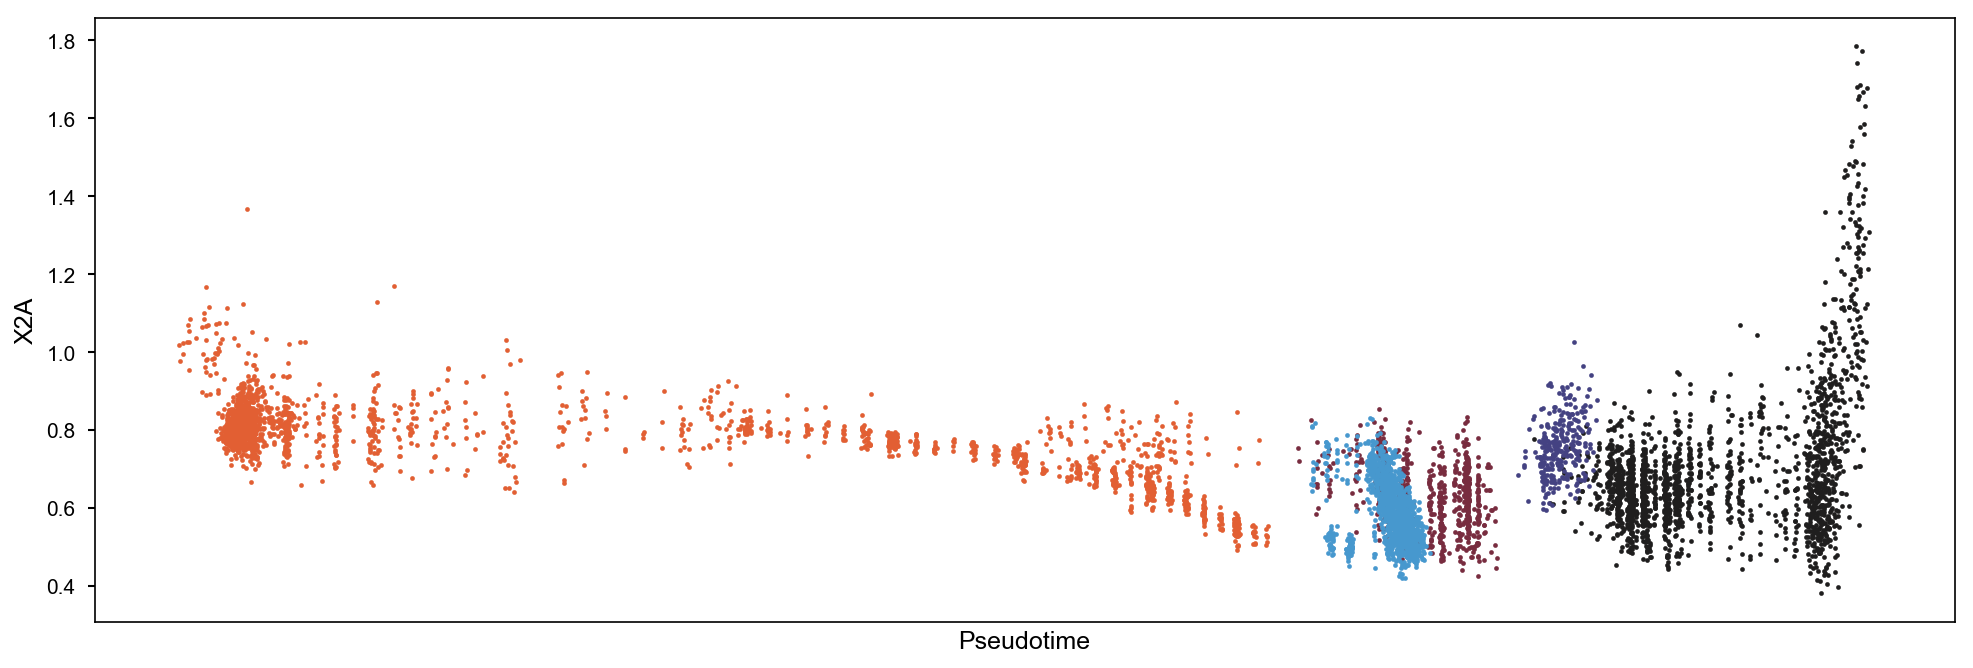

In [441]:
state_cmap = dict(zip(range(1, 6), sns.color_palette('icefire_r', n_colors=5)))

fig, ax = plt.subplots(figsize=plt.figaspect(1/3))
for g, dd in dat.groupby('State'):
    dd.plot.scatter('Pseudotime', 'X2A', ax=ax, color=state_cmap[g], s=5)
    
ax.set_xticks([])

In [136]:
ratio = (totals['chrX'] / totals['chr2R']).to_frame()

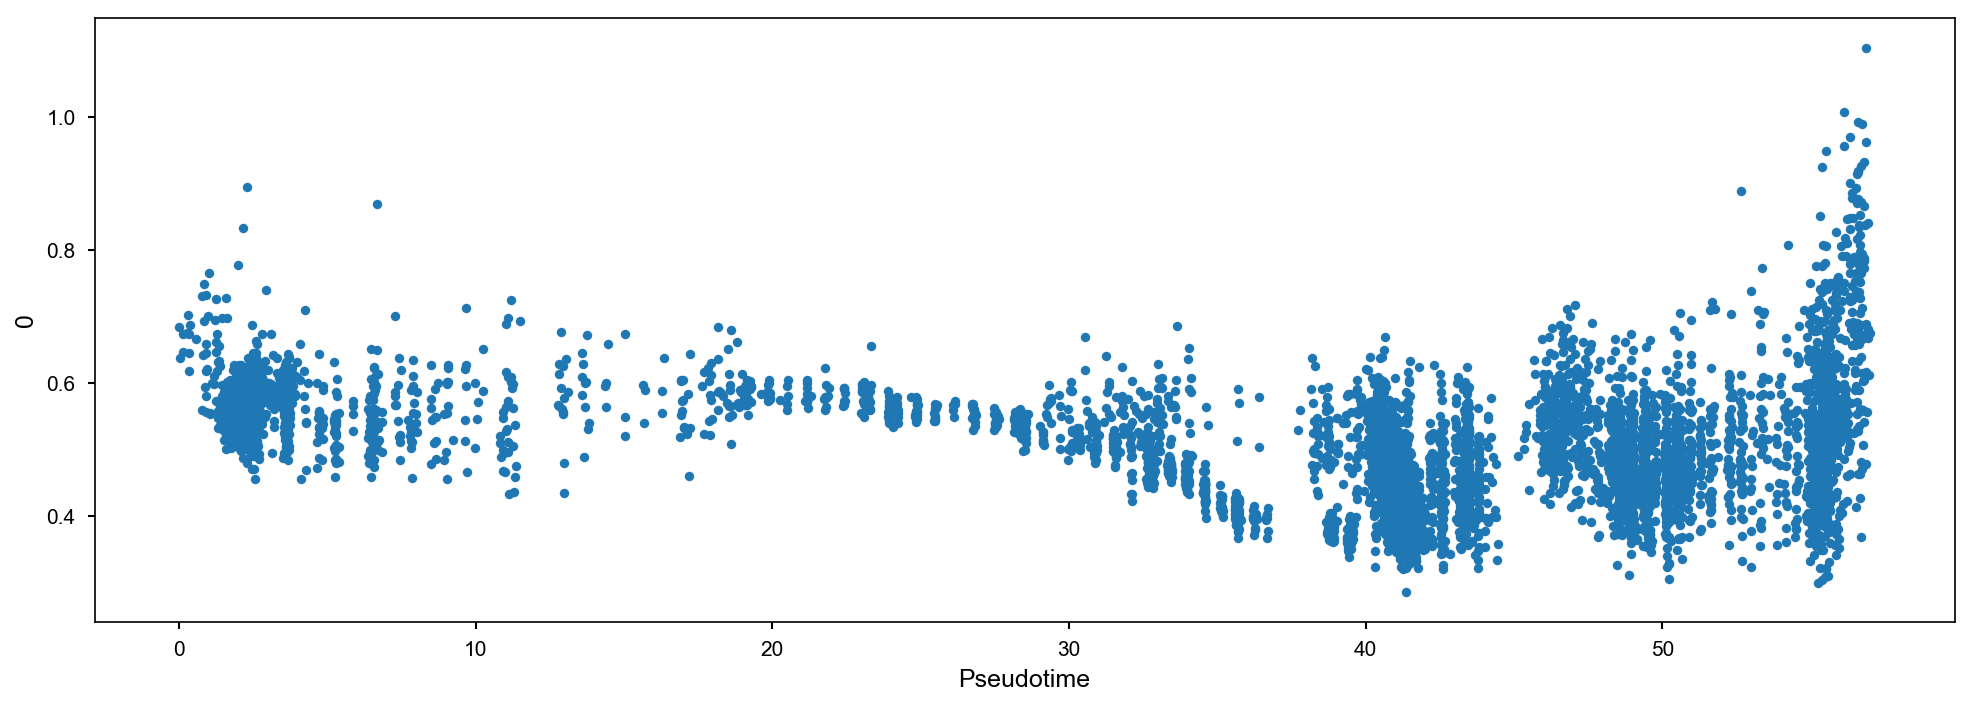

In [140]:
ratio.join(psTime).plot.scatter('Pseudotime', 0, figsize=plt.figaspect(1/3))

## DEG

In [219]:
from larval_gonad.gene_ontology import run_flyslim, run_fly

In [264]:
bg = pd.read_parquet('../output/scrnaseq-wf/tpm.parquet').index.tolist()

In [287]:
cmap2 = {
    'spermatogonia': cluster_cmap['Spermatogonia (6)'],
    'early': cluster_cmap['Early 1º Spermatocytes (3)'],
    'mid': cluster_cmap['Mid 1º Spermatocytes (2)'],
    'late': cluster_cmap['Late 1º Spermatocytes (0)'],
}

In [308]:
first='spermatogonia'
second='early'

In [310]:
def build(first, second):
    deg = pd.read_csv(f'../output/2018-06-15_scrnaseq_{first}_vs_{second}_biomarkers.tsv', sep='\t', index_col='primary_FBgn').query('p_val_adj < 0.001').avg_logFC
    up = deg.index[deg > 0].tolist()
    down = deg.index[deg < 0].tolist()

    if len(up) > 0:
        goUp = run_fly(up, bg)
    else:
        goUp = None

    if len(down) > 0:
        goDown = run_fly(down, bg)
    else:
        goDown = None

    def parse_terms(results, cell_type):
        out = []
        for i in results:
            term = i.GO
            name = i.name
            study_count = i.study_count
            long_name = f'{name} ({term})'
            logpval = -np.log10(i.p_fdr_bh)
            
            # Skip the top categories b/c they are not informative
            if name in ['biological_process', 'molecular_function', 'cellular_component']:
                continue

            out.append((long_name, cell_type, logpval, study_count))

        return out

    results = []
    if goUp:
        results.extend(parse_terms(goUp, first))

    if goDown:
        results.extend(parse_terms(goDown, second))

    df = pd.DataFrame(results, columns=['name', 'cell type', 'log-pval', 'num_genes'])
    df['comparison'] = f'{first}_{second}'
    
    return df

In [404]:
df = pd.concat([build('spermatogonia', 'early'),
                build('spermatogonia', 'mid'),
                build('spermatogonia', 'late'),
               ])

fisher module not installed.  Falling back on scipy.stats.fisher_exact
11,166 out of 14,476 population items found in association
Calculating uncorrected p-values using fisher_scipy_stats
 1,072 out of  1,121 study items found in association
Running multitest correction: statsmodels fdr_bh
  2,719 GO terms are associated with 1,072 of 1,121 study items
  7,609 GO terms are associated with 11,166 of 14,476 population items
fisher module not installed.  Falling back on scipy.stats.fisher_exact
11,166 out of 14,476 population items found in association
Calculating uncorrected p-values using fisher_scipy_stats
 1,676 out of  2,106 study items found in association
Running multitest correction: statsmodels fdr_bh
  2,123 GO terms are associated with 1,676 of 2,106 study items
  7,609 GO terms are associated with 11,166 of 14,476 population items
fisher module not installed.  Falling back on scipy.stats.fisher_exact
11,166 out of 14,476 population items found in association
Calculating uncorr

In [405]:
df2 = df.copy()
df2.loc[df2['cell type'] != 'spermatogonia', 'log-pval'] =  df2.loc[df2['cell type'] != 'spermatogonia', 'log-pval'] * -1

In [406]:
dat = df2.pivot_table(index='name', columns='comparison', values='log-pval', aggfunc='first').fillna(0)

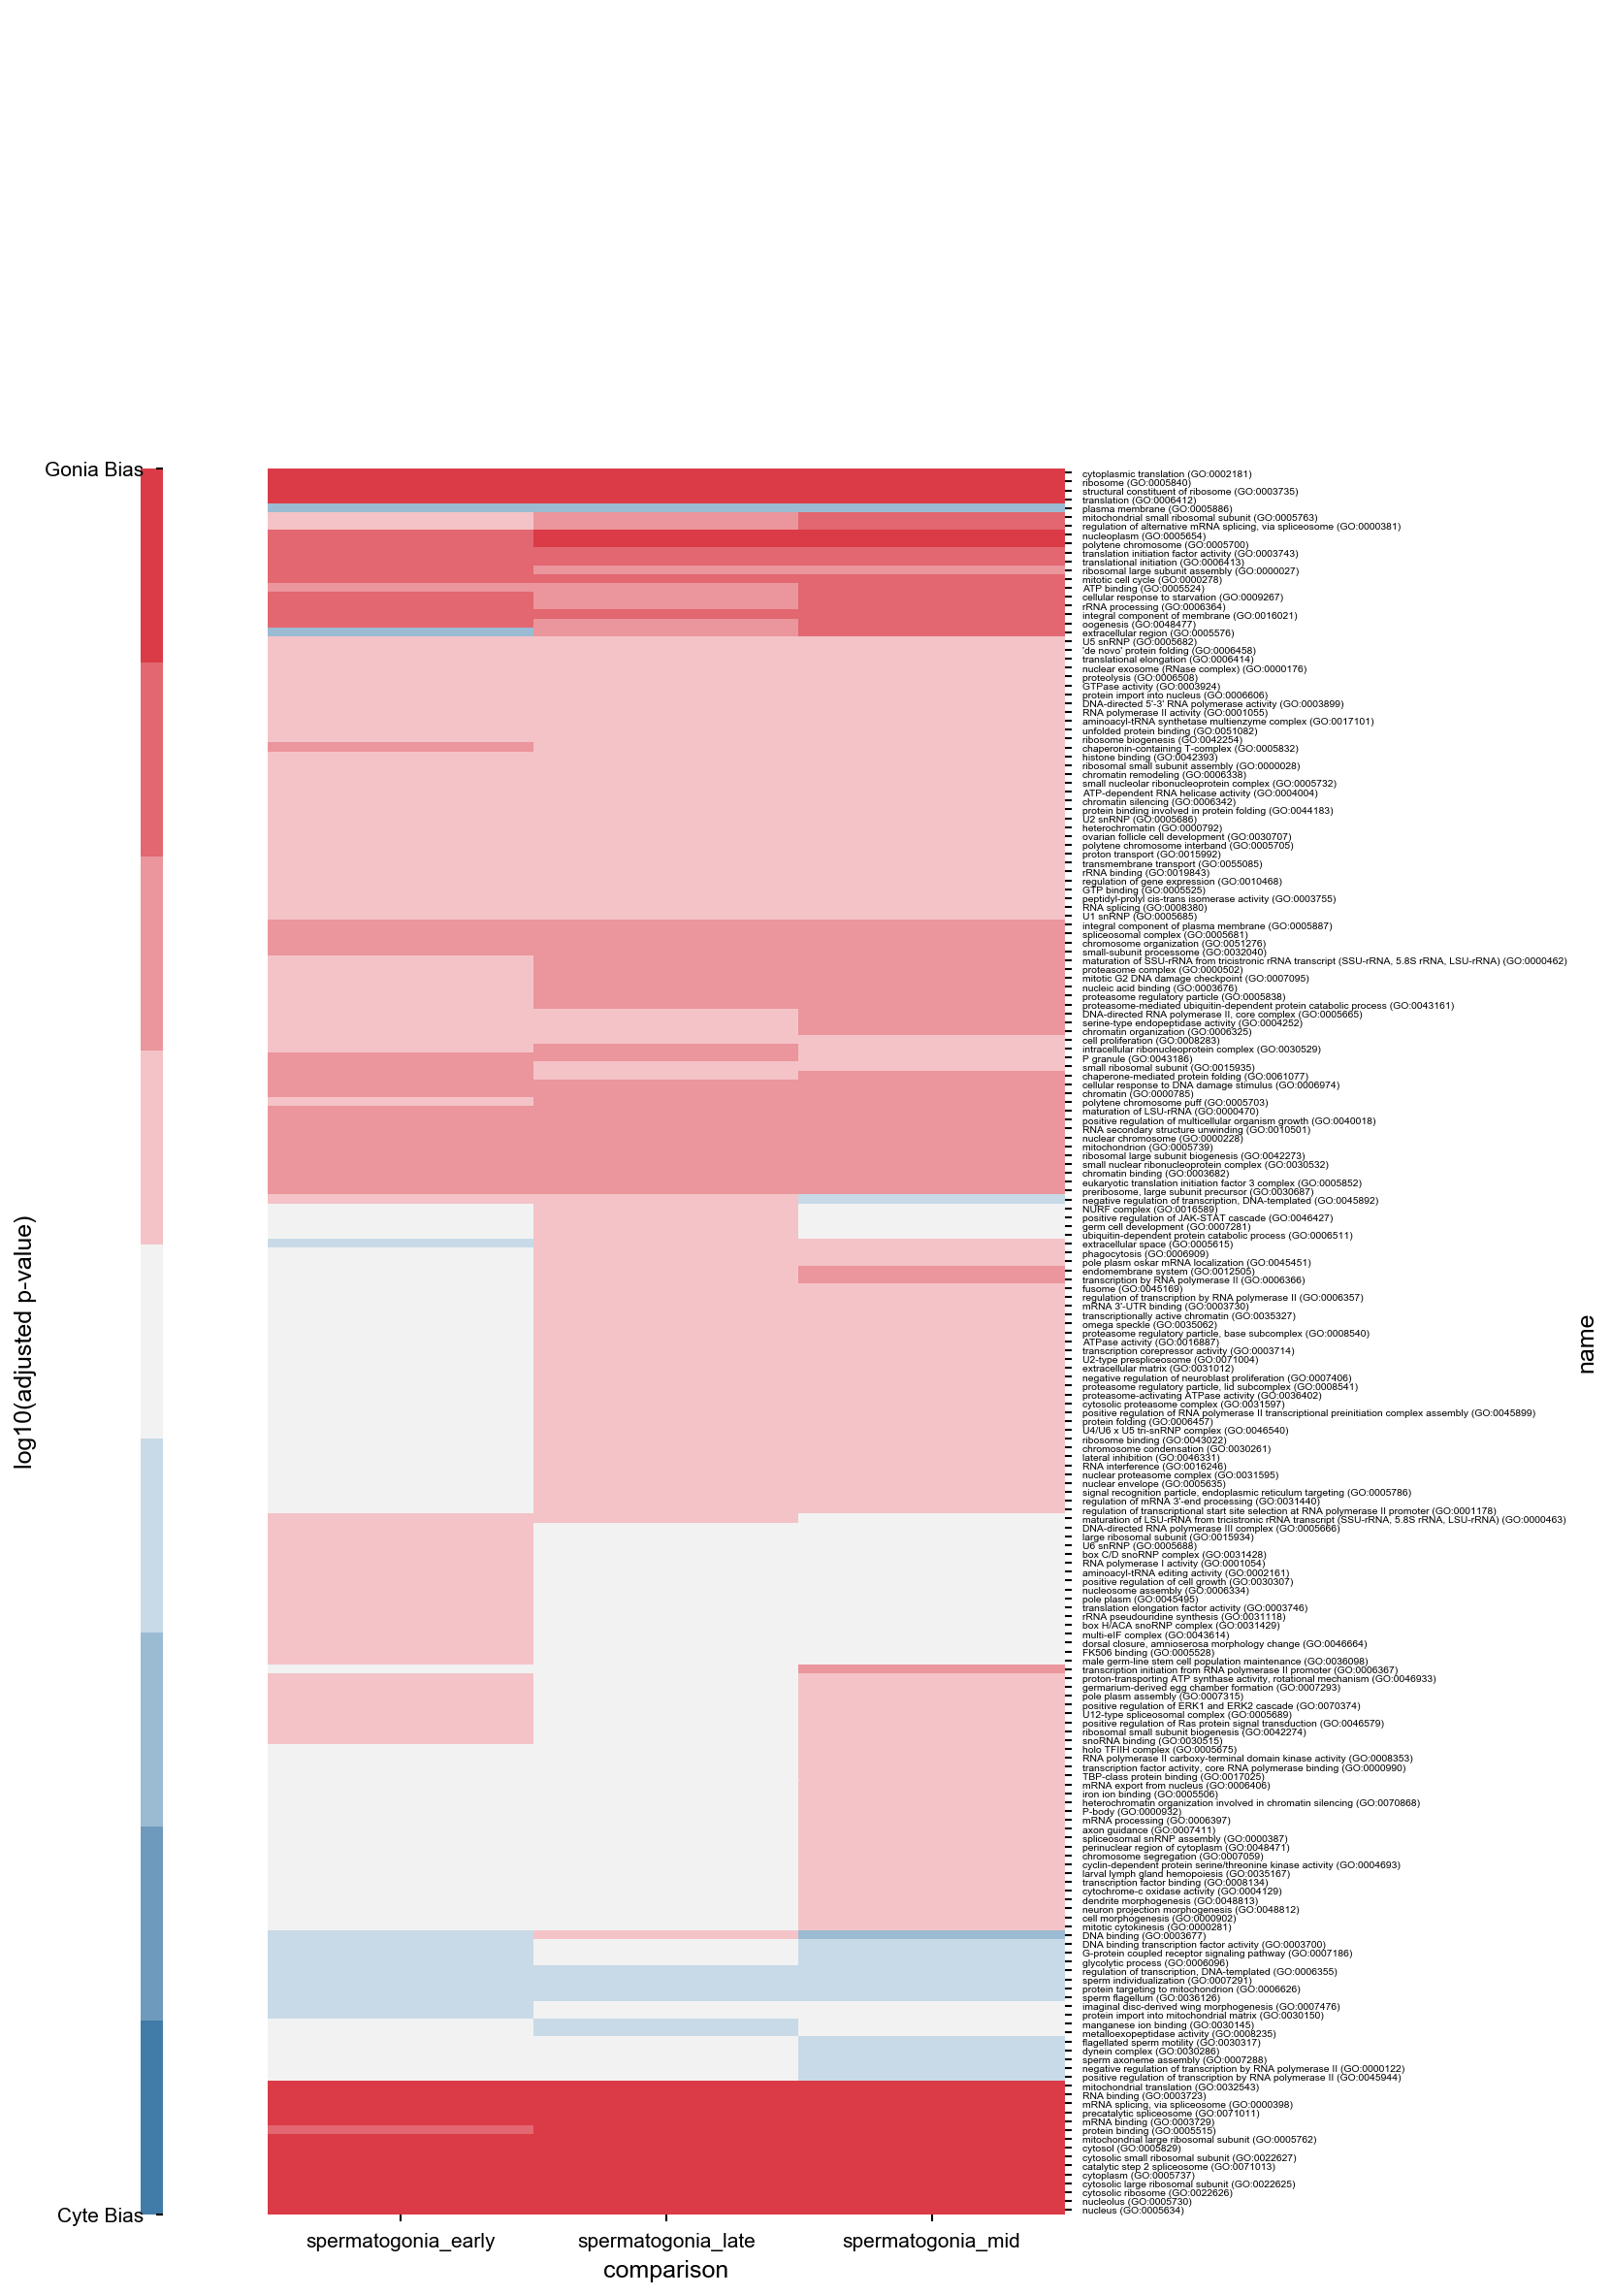

In [407]:
ax = sns.clustermap(dat, cmap=sns.diverging_palette(240, 10, n=9), vmin=-20, vmax=20, yticklabels=True, col_cluster=False, figsize=(8, 20))
ax.cax.yaxis.set_ticks([0, 1])
ax.cax.set_yticklabels(['Cyte Bias', 'Gonia Bias'])
ax.cax.set_ylabel('log10(adjusted p-value)')
ax.cax.yaxis.set_label_position('left');
plt.setp(ax.ax_heatmap.get_yticklabels(), fontsize=5);
pos = ax.ax_row_dendrogram.get_position()
pos.x1 = pos.x1 *.5
ax.ax_row_dendrogram.set_visible(False)
ax.cax.set_position(pos)
ax.cax.yaxis.set_ticks_position('left')

In [413]:
dat = df.query('comparison == "spermatogonia_mid"').copy()

In [421]:
dat.sort_values('log-pval', inplace=True, ascending=False)

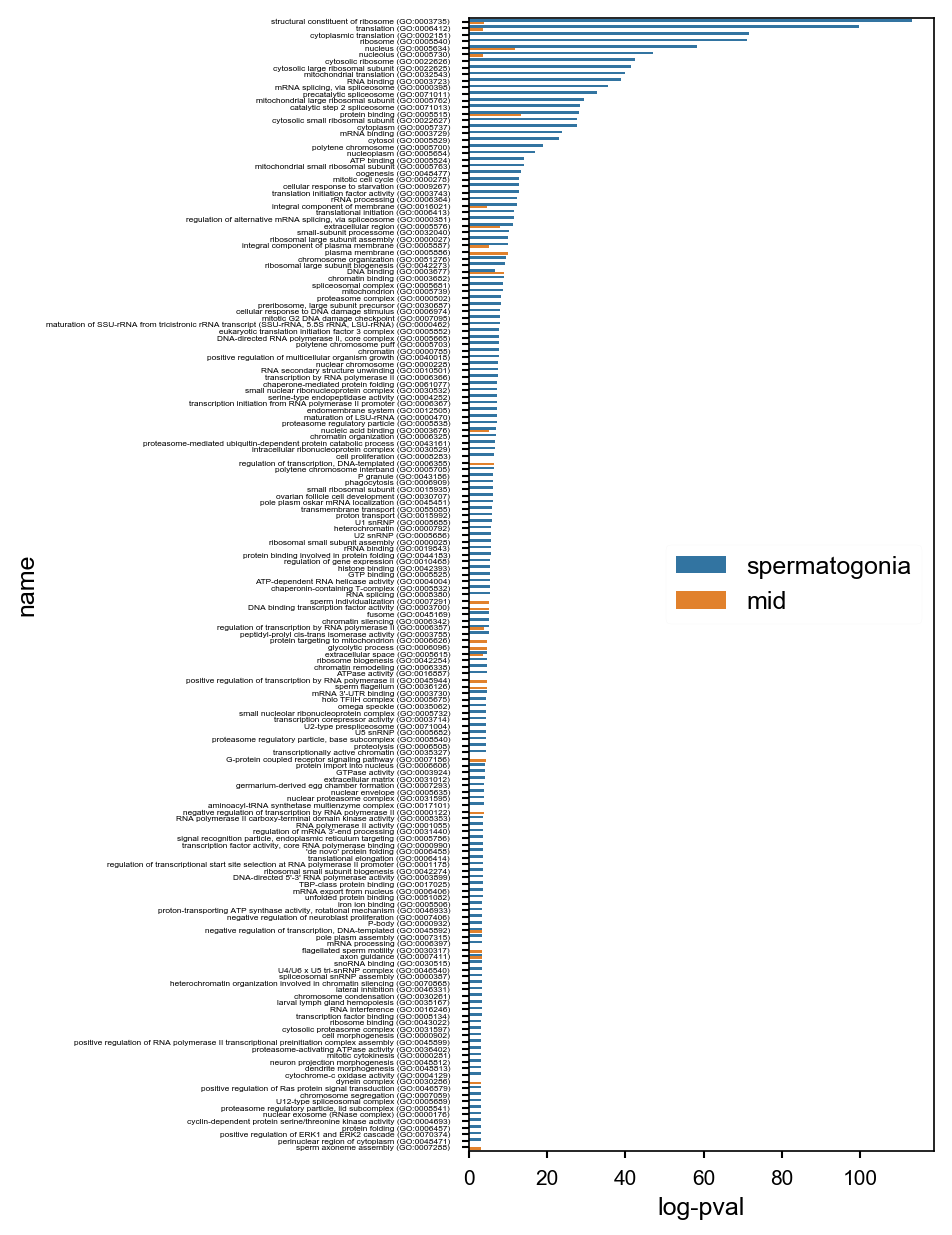

In [429]:
fig, ax =plt.subplots(figsize=(4, 10))
sns.barplot('log-pval', 'name', hue='cell type', data=dat, ax=ax)
plt.setp(ax.get_yticklabels(), fontsize=4);
ax.legend(loc='center right')

In [ ]:
ax.set_y